# Photoinjector simulation in Volume
Let's simulate a CLEAR-like photoinjector.
We need to use Volume because we need the:
* Full overlap of field maps: electron gun's electric field + solenoid field
* Time integration to correctly model space-charge effects

In [1]:
%plot -f SVG

In [2]:
RF_Track;


RF-Track, version 2.3.3a0

Copyright (C) 2016-2025 CERN, Geneva, Switzerland. All rights reserved.

Author and contact:
 Andrea Latina <andrea.latina@cern.ch>
 BE-ABP Group
 CERN
 CH-1211 GENEVA 23
 SWITZERLAND

This software is distributed under a CERN proprietary software
license in the hope that it will be useful, but WITHOUT ANY WARRANTY;
not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.

See the COPYRIGHT and LICENSE files at the top-level directory of
the RF-Track download area: https://gitlab.cern.ch/rf-track

RF-Track was compiled with GSL-2.7 and fftw-3.3.10



In [3]:
addpath('scripts/')

## Define the key parameters

In [4]:
Setup.Bz = 0.25; % T, solendoid peak field
Setup.Ez = 100; % MV/m, gun peak electric field at the cathode
Setup.PHID = 140; % deg, gun phase

Q_pC = 50; % pC, bunch charge extracted
sigr = 0.8; % mm, laser spot size at the cathode
sigt = 1.2; % ps, laser pulse length

## Beam creation at cathode
To create a suitable particles distribution, we can use a generator similar to the ASTRA's one. For more information, see [HERE](https://indico.cern.ch/event/1186676/).

In [5]:
%% Beam creation at cathode
G = Bunch6dT_Generator();

G.species = 'electrons';          % species
G.cathode = true;                 % cathode, true or false
G.noise_reduc = true;             % noise reduction (quasi-random)
G.q_total = Q_pC/1e3;             % nC bunch charge
G.ref_ekin = 0;                   % MeV energy of reference particle
G.ref_zpos = 0;                   % m position of reference particle
G.ref_clock = 0;                  % ns clock of reference particle
G.phi_eff = 3.5;                  % eV, effective work function
G.e_photon = 4.73;                % eV, photon energy for Fermi-Dirac distribution.
G.dist_x = 'g';                   % Specifies the transverse particle distribution in the horizontal direction.
G.dist_y = 'g';                   % Specifies the transverse particle distribution in the vertical direction.
G.sig_x = sigr;                   % mm, rms bunch size in the horizontal direction. Also the vertical bunch size if Dist_x = radial.
G.sig_y = sigr;                   % mm, rms bunch size in the vertical direction.
G.sig_t = sigt/1e3;               % ns, rms value of the emission time, i.e. the bunch length if generated from a cathode
G.c_sig_x = 3;                    % cuts off a Gaussian horizontal distribution
G.c_sig_y = 3;                    % cuts off a Gaussian vertical distribution
G.c_sig_t = 3;                    % cuts off a Gaussian longitudinal distribution
G.dist_pz = 'fd_300';             % Emission from cathode following a Fermi-Dirac dist. (for z)

Nparticles = 5000; % number of macroparticles
B0 = Bunch6dT (G, Nparticles);

Since FD_300 is defined, a 3D Fermi Dirac disribution will be created in px,py,pz


ans =

  -0.0000   0.0003  -0.3436   0.0002        0   0.0006
  -0.5379   0.0002   0.3436   0.0005        0   0.0006
   0.5379  -0.0001  -0.9721   0.0006        0   0.0007
  -0.9164  -0.0005  -0.1115   0.0005        0   0.0007
   0.2542  -0.0007   0.6098   0.0002        0   0.0007
  -0.2542  -0.0007  -0.6098  -0.0002        0   0.0007
   0.9164  -0.0002   0.1115  -0.0002        0   0.0003
  -1.2197  -0.0001   0.9721  -0.0005        0   0.0005
   0.1255   0.0002  -1.4167  -0.0005        0   0.0006
  -0.3899   0.0004  -0.2640  -0.0003        0   0.0008

ans =

  -0.301735
  -0.090890
   0.090890
   0.301735
  -0.624691
  -0.253281
  -0.054164
   0.128593
   0.356402
  -0.502746

t_emission = 2.1300


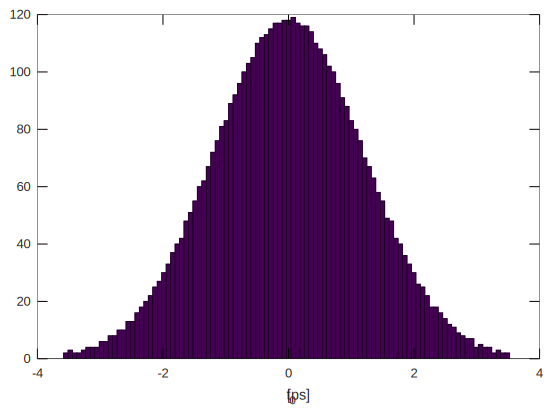

In [6]:
% Let's display the phase space, which, for a Bunch6dT, is by default X Px Y Py Z Pz

M0 = B0.get_phase_space(); % X [mm]   Px [MeV/c]   Y [mm] Py [MeV/c] Z [mm]  Pz [MeV/c]
M0(1:10,:)

t0 = B0.get_phase_space('%t0'); % mm/c
t0(1:10)

hist(t0 / RF_Track.ps, 100)
xlabel('t_0 [ps]')

t_emission = range(t0)

## We load the gun and the solenoid field maps

In [7]:
[Gun,GunS] = init_gun (Setup);
[Sol,SolS] = init_solenoid (Setup);

In [8]:
GunS
SolS

GunS = 0
SolS = -1.0630


We add the elements to the Volume using: ```V.add (Gun, ...);```
* ```V.add (Gun, X, Y, Z, 'entrance');```
* ```V.add (Gun, X, Y, Z, ROLL, PITCH, YAW, 'entrance');```

In [9]:
## We define the volume
V = Volume();

# Add the elements
V.add (Gun, 0, 0, GunS, 'entrance');
V.add (Sol, 0, 0, SolS);

# Set the boundaries of the volume
V.set_s0 (0.0); % entrance boundary
V.set_s1 (1.0); % exit boundary

In [10]:
V.get_s0()
V.get_s1()

ans =

   0   0   0   1   0   0   0

ans =

      0      0   1000      1      0      0      0



## Let's plot the fields

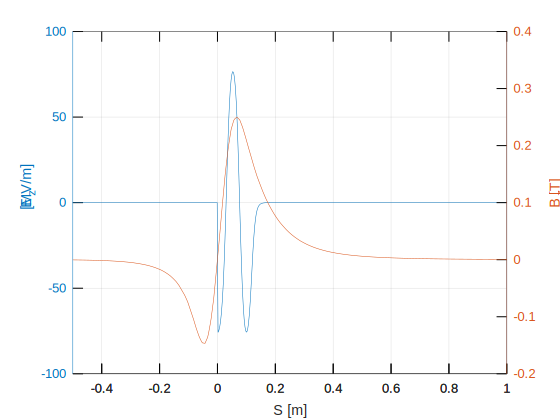

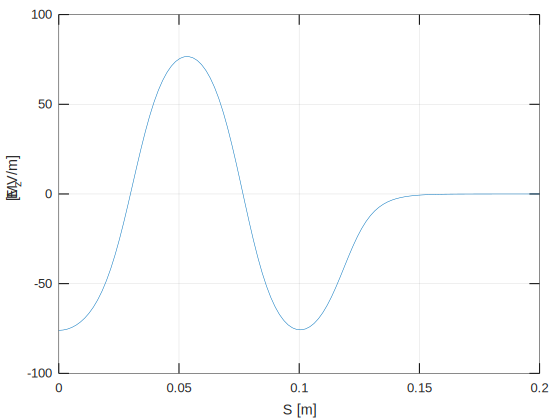

In [11]:
Za = linspace(-500, 1000, 500); % mm, Z axis

[E,B] = V.get_field ( 0, 0, Za, 0 ); %% X, Y, Z, T

ax = plotyy(Za/1e3, E(:,3)/1e6, Za/1e3, B(:,3));
xlabel('S [m]')
ylabel(ax(1), 'E_z [MV/m]');
ylabel(ax(2), 'B_z [T]');
grid on

figure
Za = linspace(0, 200, 500); % mm, Z axis

[E,B] = V.get_field ( 0, 0, Za, 0 ); %% X, Y, Z, T

plot(Za/1e3, E(:,3)/1e6);
xlabel('S [m]')
ylabel('E_z [MV/m]');
grid on

We need now to setup the tracking options

In [12]:
V.odeint_algorithm = 'rk2'; % pick your favourite algorithm, 'rk2', 'rkf45', 'leapfrog', and 'analytic' are valid options
V.dt_mm = 0.1; % mm/c, integration step size
V.sc_dt_mm = 5; % mm/c, the time step of the space-charge effect calculation
V.tt_dt_mm = 5; % mm/c, the time step with which the transport table is filled

Now we can perform tracking

In [13]:
tic
B1 = V.track(B0);
toc

Elapsed time is 11.6891 seconds.


## Phase space plots

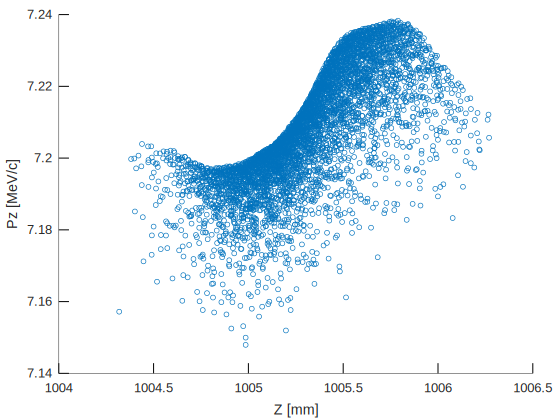

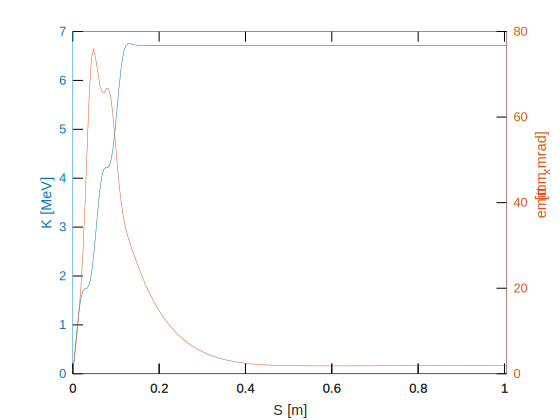

In [14]:
M1 = B1.get_phase_space(); % X Px Y Py Z Pz
figure
scatter(M1(:,5), M1(:,6));
xlabel('Z [mm]')
ylabel('Pz [MeV/c]')

T = V.get_transport_table('%t %mean_Z %mean_K %emitt_x');
figure
ax = plotyy(T(:,2)/1e3, T(:,3), T(:,2)/1e3, T(:,4));
xlabel('S [m]')
ylabel(ax(1), 'K [MeV]');
ylabel(ax(2), 'emitt_x [mm.mrad]');

Volume uses Z and Pz as longitudinal phase space coordinates (canonical pair)
Lattice uses t and E as longitudinal phase space coordinates (canonical pair)

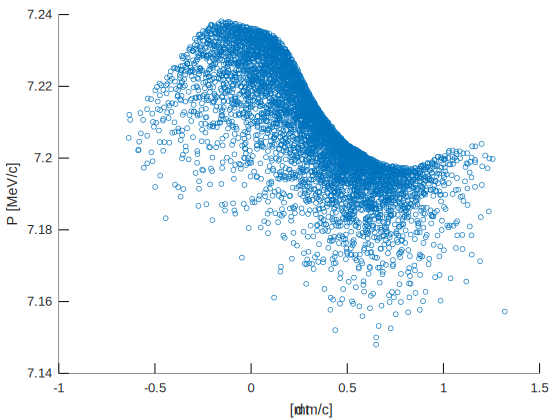

In [15]:
B1_6d = V.get_bunch_at_s1(); % Bunch6d (useful in Lattice)
M1_6d = B1_6d.get_phase_space('%dt %P');

figure
scatter(M1_6d(:,1), M1_6d(:,2));
xlabel('d{t} [mm/c]')
ylabel('P [MeV/c]')

## Adjusting the space charge calculation and considering the effect of cathode mirror charges
Cathode mirror charges affect the beam dynamics through space-charge forces and can alter the effective charge extracted from a cathode.

We can set them by setting the RF-Track's space-charge computing engine accordingly. (This is typically done at the beginning of a script.)

In [16]:
%% Let's customize the SC algorithm.

SC = SpaceCharge_PIC_FreeSpace (32, 32, 32); % The three inputs are the number of mesh cells in X, Y, and Z.
SC.set_smooth (0.5); % set smooth factor
SC.set_mirror (0.0); % set position of cathode

%% Set RF-Track to use 'SC' for space-charge calculations
RF_Track.SC_engine = SC;

### Let's re-run the simulation

In [17]:
tic
B1 = V.track(B0);
toc

Elapsed time is 11.8533 seconds.


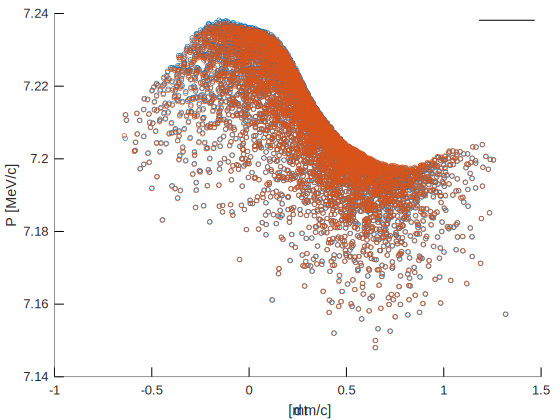

In [18]:
B1_6d = V.get_bunch_at_s1(); % Bunch6d
M1_6d_mirror = B1_6d.get_phase_space('%dt %P');

figure
hold on
scatter(M1_6d(:,1), M1_6d(:,2));
scatter(M1_6d_mirror(:,1), M1_6d_mirror(:,2));
legend('without mirror charges', 'with mirror charges');
xlabel('d{t} [mm/c]')
ylabel('P [MeV/c]')

## Using Volume as a Lattice element
A Volume can be inserted into a Lattice. In this case, the incoming Bunch6d is placed at s0, and the tracking continues in Volume until the particles reach s1.

Let's see an example:

In [ ]:
L = Lattice();
L.append (V);
L.append (LINAC);